In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plot library

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.
#! /usr/bin/env python
# -*- coding: utf-8 -*- 
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle

def one_hot(Y_int, max_num):
    return np.eye(max_num)[Y_int]
    
train_data0 = pd.read_csv("MNIST_data/train.csv")
train_data = np.array(train_data0.iloc[:, 1:785])
train_label = np.array(train_data0.iloc[:,0])


# One-hot encoding
train_label = one_hot(train_label, 10)

test_data0 = pd.read_csv("MNIST_data/test.csv")
test_data = np.array(test_data0)

In [62]:
print(np.array(train_data0.iloc[:,0])[:10])
print('is equivalent to:')
print(train_label[:10])


[1 0 1 4 0 0 7 3 5 3]
is equivalent to:
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


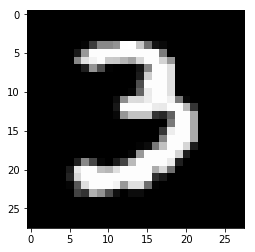

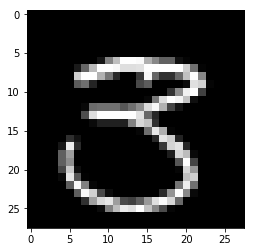

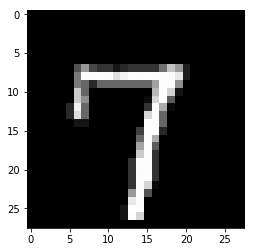

In [39]:
pixels = train_data[9].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

pixels = train_data[7].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

pixels = train_data[6].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [63]:
# Define hyperparameters
learning_rate = 0.0001
epoch = 7
batch_size = 20

# Define network parameters
n_input = 784
n_classes = 10

# Placeholder
X = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Convolution
def conv2d(name, x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    #return tf.nn.relu(x, name=name)
    return tf.nn.elu(x, name=name)

# Pooling
def maxpool2d(name, x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME', name=name)

weights = {
    'W1': tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1)),
    'W2': tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1)),
    'W4': tf.Variable(tf.truncated_normal([64 * 7 * 7, 784], stddev=0.1)),
    'Wo': tf.Variable(tf.truncated_normal([784, n_classes], stddev=0.1))
}

biases = {
    'b1': tf.Variable(tf.random_normal([32], stddev=0.1)),
    'b2': tf.Variable(tf.random_normal([64], stddev=0.1)),
    'b4': tf.Variable(tf.random_normal([784], stddev=0.1)),
    'bo': tf.Variable(tf.random_normal([n_classes], stddev=0.1))
}

In [64]:
def model(X, weights, biases):
    # Conv1
    x = tf.reshape(X, [-1, 28, 28, 1])
    
    # confine range to between 0 and 1
    x = x/255.
    
    #conv1 = tf.nn.relu(conv2d('conv1', x, weights['W1'], biases['b1']))
    conv1 = tf.nn.elu(conv2d('conv1', x, weights['W1'], biases['b1']))
    # Pool1
    pool1 = maxpool2d('pool1', conv1, k=2)

    # Conv2
    #conv2 = tf.nn.relu(conv2d('conv2', pool1, weights['W2'], biases['b2']))
    conv2 = tf.nn.relu(conv2d('conv2', pool1, weights['W2'], biases['b2']))

    # Pool2
    pool2 = maxpool2d('pool2', conv2, k=2)
    
    # Full connect layer
    fc = tf.reshape(pool2, [-1, weights['W4'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weights['W4']), biases['b4'])
    #fc = tf.nn.relu(fc)
    fc = tf.nn.elu(fc)

    # output
    a = tf.add(tf.matmul(fc, weights['Wo']), biases['bo'])

    return a


# prediction
pred = model(X, weights, biases)

# cost
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
label = tf.argmax(pred, 1)
# evaluation
correct_pred = tf.equal(label, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True  
with tf.Session(config=config) as sess:
    sess.run(init)  
    for e in range(epoch):
        step = 1
        while step*batch_size <= train_data.shape[0]:
            xs, ys = train_data[(step-1)*batch_size:step*batch_size, :], train_label[(step-1)*batch_size:step*batch_size, :]
            sess.run(optimizer, feed_dict={X:xs, y:ys})

            if step % 100 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X:xs, y:ys})

                print("Iter {0}, Minibatch Loss = {1}, Training accuracy = {2}".format(str(step),
                                                                                    loss, acc))
            step += 1
    print("Optimization Completed")
    test_labels = []
    for i in range(1000):
        xs, ys = test_data[i*28:(i+1)*28, :], test_data[i*28:(i+1)*28, 0:10]
        pred_ = sess.run(label, feed_dict={X:xs, y:ys})
        test_labels.extend(list(pred_))

f1 = open('label', 'wb')
pickle.dump(test_labels, f1)
f1.close()


# now we save the predictions to a csv ready for submission
df = pd.DataFrame({'Label': test_labels})
# Add 'ImageId' column
df1 = pd.concat([pd.Series(range(1,28001), name='ImageId'), 
                              df[['Label']]], axis=1)


df1.to_csv('submission_blackrains.csv', index=False)

Iter 100, Minibatch Loss = 0.19799865782260895, Training accuracy = 0.8999999761581421
Iter 200, Minibatch Loss = 0.2519868016242981, Training accuracy = 0.8999999761581421
Iter 300, Minibatch Loss = 0.17422299087047577, Training accuracy = 0.8999999761581421
Iter 400, Minibatch Loss = 0.7882970571517944, Training accuracy = 0.800000011920929
Iter 500, Minibatch Loss = 0.22893980145454407, Training accuracy = 0.8999999761581421
Iter 600, Minibatch Loss = 0.15653134882450104, Training accuracy = 1.0
Iter 700, Minibatch Loss = 0.12648576498031616, Training accuracy = 0.949999988079071
Iter 800, Minibatch Loss = 0.04573901742696762, Training accuracy = 1.0
Iter 900, Minibatch Loss = 0.0381118580698967, Training accuracy = 1.0
Iter 1000, Minibatch Loss = 0.03287963196635246, Training accuracy = 1.0
Iter 1100, Minibatch Loss = 0.053016383200883865, Training accuracy = 0.949999988079071
Iter 1200, Minibatch Loss = 0.03647300973534584, Training accuracy = 1.0
Iter 1300, Minibatch Loss = 0.014

Iter 300, Minibatch Loss = 0.0006253972533158958, Training accuracy = 1.0
Iter 400, Minibatch Loss = 0.025972869247198105, Training accuracy = 1.0
Iter 500, Minibatch Loss = 0.01020946353673935, Training accuracy = 1.0
Iter 600, Minibatch Loss = 0.0007903411169536412, Training accuracy = 1.0
Iter 700, Minibatch Loss = 0.014329495839774609, Training accuracy = 1.0
Iter 800, Minibatch Loss = 0.0014428177382797003, Training accuracy = 1.0
Iter 900, Minibatch Loss = 0.0004811958351638168, Training accuracy = 1.0
Iter 1000, Minibatch Loss = 0.0008854383486323059, Training accuracy = 1.0
Iter 1100, Minibatch Loss = 0.004115102346986532, Training accuracy = 1.0
Iter 1200, Minibatch Loss = 0.003029750194400549, Training accuracy = 1.0
Iter 1300, Minibatch Loss = 0.00031023973133414984, Training accuracy = 1.0
Iter 1400, Minibatch Loss = 0.002228306606411934, Training accuracy = 1.0
Iter 1500, Minibatch Loss = 0.0010087150149047375, Training accuracy = 1.0
Iter 1600, Minibatch Loss = 0.00922559